# Introduction
Point of this notebook is simply to observe (withotu any decision making) the performance across a matrix of window skips and window lengths

In [1]:
from sampleddetection.environment.datastructures import Action, State
from sampleddetection.environment.model import Environment
from sampleddetection.datastructures.flowsession import SampledFlowSession
from sampleddetection.common_lingo import Attack
import numpy as np
from typing import List
import os
from tqdm.notebook import tqdm
from pathlib import Path
from itertools import product
import random

# Make sure these are reloaded when cells are rerun
%load_ext autoreload
%autoreload 2

In [2]:
# Setup the environment
# From Microsecond to dekasecond
window_skips    = np.logspace(-6, 1, 1, dtype=float) # DEBUG: This is like this while we test lengths 
window_lengths  = np.logspace(-6, -3, 4, dtype=float)
#window_lengths  = 2*np.linspace(0.01, , 3, dtype=float)
batch_size      = 16
multiclass_classifcation = True # If false, we label all attacks as 1
csv_path = './data/Wednesday.csv'
dataset_dir    = './data/precalc_windows/'
dataset_filename = 'ws_{}_wl_{}.csv'
desired_features = [
            # Debugging info
            "start_ts",
            "start_timestamp",
            "end_timestamp",
            "tot_fwd_pkts",
            "tot_bwd_pkts",
            # Non debugging
            "label",
            "fwd_pkt_len_max",
            "fwd_pkt_len_min",
            "fwd_pkt_len_mean",
            "bwd_pkt_len_max",
            "bwd_pkt_len_min",
            "bwd_pkt_len_mean",
            "flow_byts_s",
            "flow_pkts_s",
            "flow_iat_mean",
            "flow_iat_max",
            "flow_iat_min",
            "fwd_iat_mean",
            "fwd_iat_max",
            "fwd_iat_min",
            "bwd_iat_max",
            "bwd_iat_min",
            "bwd_iat_mean",
            "pkt_len_min",
            "pkt_len_max",
            "pkt_len_mean",
]
attacks_to_detect = [
    Attack.SLOWLORIS,
    Attack.SLOWHTTPTEST,
    Attack.HULK,
    Attack.GOLDENEYE,
    #Attack.HEARTBLEED. # Takes to long find in dataset.
]

# Use product to get a matrix of combinations
options_matrix = list(product(window_skips, window_lengths))
print(f"Working with {len(options_matrix)} permutaitions")

Working with 4 permutaitions


In [3]:
# Create or Load dataset
from sampleddetection.samplers.window_sampler import DynamicWindowSampler
from sampleddetection.writers.convenience import save_flows_to_csv
from sampleddetection.readers.readers import CSVReader
from sampleddetection.common_lingo import Attack, ATTACK_TO_STRING

sampler = DynamicWindowSampler(Path(csv_path))
environment = Environment(sampler)
min_necessary_classes = batch_size * 128

if multiclass_classifcation:
    samples_per_class = {attack: min_necessary_classes for attack in attacks_to_detect}
    samples_per_class[Attack.BENIGN] = min_necessary_classes
else: 
   samples_per_class = {Attack.BENIGN: min_necessary_classes, Attack.GENERAL: min_necessary_classes}
    
# Create it
    # Ensure that the dataset is balanced.

2024-04-02 00:45:33,151 - DynamicWindowSampler - INFO - Loading the capture file data/Wednesday.csv
2024-04-02 00:45:33,152 - DynamicWindowSampler - INFO - Loading the capture file data/Wednesday.csv
2024-04-02 00:45:33,153 - CSVReader - INFO - Reading csv...


2024-04-02 00:46:13,246 - CSVReader - INFO - CSV loaded, took  40.09 seconds with 13704955 length


In [4]:
from sampleddetection.datastructures.flow import Flow
from typing import Dict, Tuple

def generate_sessions(ws: float, wl: float) -> List[Tuple[Tuple,Flow]]:
    """Ensure we get a balanced sampling from the large dataset."""
    cur_amnt = 0
    flows: List[Tuple,Flow] = []
    if multiclass_classifcation:
        count_per_class = {attack: 0 for attack in attacks_to_detect}
        count_per_class[Attack.BENIGN] = 0
        total_amount = min_necessary_classes*(len(attacks_to_detect)+1)
        inner_bar = tqdm(total=total_amount,desc=f'Generating ws: {ws}- wl: {wl} flow',leave=False)
    else:
        count_per_class = {Attack.BENIGN: 0, Attack.GENERAL: 0}
        total_amount = min_necessary_classes*2
        inner_bar = tqdm(total=total_amount,desc=f'Generating ws: {ws}- wl: {wl} flow',leave=False)


    while sum(list(count_per_class.values())) < total_amount:

        flow_sesh =  environment.reset(winskip=ws,winlen=wl).flow_sesh
        #amnt_sesh_flows = len(flow_sesh.flows.keys())
        # Count the distributions
        label_distributions = flow_sesh.flow_label_distribution()
        # For now just predict binary attack-benining
        for kflow, flow in flow_sesh.flows.items() : 
            if multiclass_classifcation:
                label = flow.label
            else:
                label = Attack.GENERAL if flow.label != Attack.BENIGN else Attack.BENIGN

            if label not in count_per_class or count_per_class[label] >= min_necessary_classes:
                continue # Dont over add

            count_per_class[label] += 1

            flows.append((kflow,flow))

            inner_bar.update(1)
    return flows

In [5]:

flows = {}
# Set random seeds:
np.random.seed(0)
random.seed(0)
import csv


# Generate the datasets
for ws, wl in tqdm(options_matrix,desc='Creating datasets'):
    # Check if datasets exists
    flows = {f"ws:{ws}-ws:{wl}" : []}
    target_name = os.path.join(dataset_dir,dataset_filename.format(ws, wl))
    if os.path.exists(target_name):
        print(f"Will later be Loading {dataset_filename.format(ws, wl)} from {dataset_dir}")
        continue
    sesh = generate_sessions(ws,wl)

    ds_path = os.path.join(dataset_dir,dataset_filename.format(ws, wl))
    save_flows_to_csv(sesh, ds_path, desired_features=desired_features, samples_per_class=samples_per_class,overwrite=True, multiclass=multiclass_classifcation)
    
!notify-send done


Creating datasets:   0%|          | 0/4 [00:00<?, ?it/s]

Will later be Loading ws_1e-06_wl_1e-06.csv from ./data/precalc_windows/
Will later be Loading ws_1e-06_wl_1e-05.csv from ./data/precalc_windows/
Will later be Loading ws_1e-06_wl_0.0001.csv from ./data/precalc_windows/
Will later be Loading ws_1e-06_wl_0.001.csv from ./data/precalc_windows/


In [6]:
# Load PreCalced datasets
for ws, wl in tqdm(options_matrix,desc='Loading datasets'):
    target_name = os.path.join(dataset_dir,dataset_filename.format(ws, wl))
    if not os.path.exists(target_name):
        print(f"Could not find {target_name}")
        raise FileNotFoundError

Loading datasets:   0%|          | 0/4 [00:00<?, ?it/s]

# Training Model on Different Schedules

We will use the matrix of different parameters to see how the training changes performance.

In [7]:
# This will be a function that will take flows calculated/loaded up above and will train the model. 
# It will return data of  the training and testing results to later be plotted in a loop that will call it
import pandas as pd
from sampleddetection.util.data import clean_dataset,train_classifier_XGBoost,train_multinary_classier_XGBoost
from sklearn.model_selection import train_test_split
features = [
            "label",
            "fwd_pkt_len_max",
            "fwd_pkt_len_min",
            "fwd_pkt_len_mean",
            "bwd_pkt_len_max",
            "bwd_pkt_len_min",
            "bwd_pkt_len_mean",
            "flow_byts_s",
            "flow_pkts_s",
            "flow_iat_mean",
            "flow_iat_max",
            "flow_iat_min",
            "fwd_iat_mean",
            "fwd_iat_max",
            "fwd_iat_min",
          #  "bwd_iat_max",
            "bwd_iat_min",
            "bwd_iat_mean",
            "pkt_len_min",
            "pkt_len_max",
            "pkt_len_mean",
]


def evaluate_performance(df: pd.DataFrame, ws: float, wl: float) -> Dict:
    """Evaluate the performance of the model with the given dataset."""
    # Clean the dataset
    df_ddos = clean_dataset(df,features, attacks_to_detect, group_attacks=False)

    # Train the Model
    X_train, X_test, y_train, y_test = train_test_split(
        df_ddos.drop(columns=["label"]), df_ddos["label"], test_size=0.3
    )

    #mode, evals = train_classifier_XGBoost(X_train,  y_train,X_test, y_test)
    mode, evals =  train_multinary_classier_XGBoost(X_train,  y_train,X_test, y_test)

    return evals
    

In [8]:
# This will be the outer loop that will vall evaluete_performance
accuracies = []
log_losses = []
roc_aucs = []
for ws, wl in tqdm(options_matrix,desc='Evaluating datasets'):
    target_name = os.path.join(dataset_dir,dataset_filename.format(ws, wl))
    if not os.path.exists(target_name):
        print(f"Could not find {target_name}")
        raise FileNotFoundError
    # Load the data
    df = pd.read_csv(target_name)
    # Evaluate the data
    metrics = evaluate_performance(df, ws, wl)
    accuracies.append(metrics["accuracy"])
    log_losses.append(metrics["log_loss"])
    #roc_aucs.append(metrics["roc_auc"])

# Plot

Evaluating datasets:   0%|          | 0/4 [00:00<?, ?it/s]

label
4    1200
3    1200
1    1200
0    1200
2    1200
Name: count, dtype: int64
 20%|██        | 5/25 [00:03<00:15,  1.30trial/s, best loss: -0.6376190476190476]
Best parameters: {'gamma': 3, 'max_depth': 15, 'min_child_weight': 3.0, 'n_estimators': 100, 'subsample': 1}
label
0    1200
2    1200
4    1200
1    1200
3    1200
Name: count, dtype: int64
 32%|███▏      | 8/25 [00:01<00:03,  4.80trial/s, best loss: -0.6919047619047619]
Best parameters: {'gamma': 0, 'max_depth': 15, 'min_child_weight': 9.0, 'n_estimators': 90, 'subsample': 1}
label
2    1200
4    1200
3    1200
0    1200
1    1200
Name: count, dtype: int64
 28%|██▊       | 7/25 [00:01<00:04,  3.61trial/s, best loss: -0.7088095238095239]
Best parameters: {'gamma': 0, 'max_depth': 40, 'min_child_weight': 3.0, 'n_estimators': 80, 'subsample': 0.9}
label
3    1200
0    1200
4    1200
2    1200
1    1200
Name: count, dtype: int64
 32%|███▏      | 8/25 [00:02<00:04,  3.54trial/s, best loss: -0.7747619047619048]
Best parameters: 

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

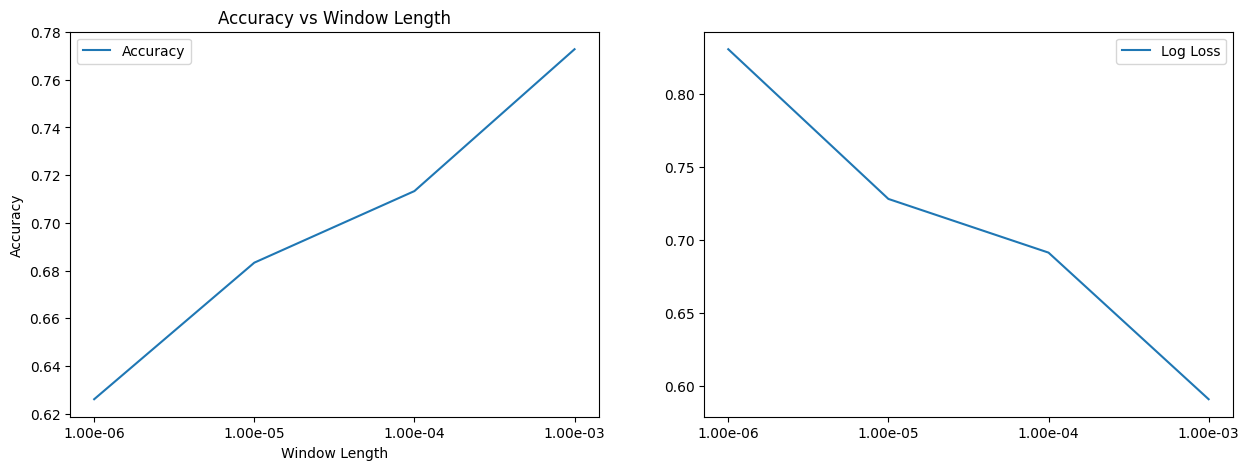

In [18]:
# Simple Graph disregarding winskips

# Setup the figure
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

wl_notation = [f"{wl:.2e}" for wl in window_lengths]

# Plot dotted curve  with seaborn
sns.lineplot(x=wl_notation, y=accuracies, ax=ax[0], label="Accuracy")
sns.lineplot(x=wl_notation, y=log_losses, ax=ax[1], label="Log Loss")

# Set the labels
ax[0].set_xlabel("Window Length")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Accuracy vs Window Length")
ax[0].legend()




In [ ]:
# Heat Map Plotting(FOR BINARY CLASSIFICATION ONLY FOR NOW)
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import LogFormatter
from matplotlib.ticker import FormatStrFormatter

#winskips = [f"{ws:.2f}" for ws, wl in options_matrix]
#winlens = [f"{wl:.2f}" for ws, wl in options_matrix]
winskips = [f"{i:.2e}" for i in np.logspace(-6, 1, 1)]
winlens = [f"{i:.2e}" for i in np.logspace(-3, 1, 4)]
# Format these with scientific (1e-6) notation

fig, ax = plt.subplots(3,1,figsize=(5,10))

#formatter = LogFormatter(10, labelOnlyBase=False)

print(winskips)

sns.heatmap(np.array(accuracies).reshape(1,4),ax=ax[0],annot=True,fmt=".2f", xticklabels=winskips, yticklabels=winlens)
ax[0].set_title("Accuracy")
ax[0].set_xlabel("Window Length")
ax[0].set_ylabel("Window Skip")

sns.heatmap(np.array(log_losses).reshape(1,4),ax=ax[1],annot=True,fmt=".2f",xticklabels=winskips, yticklabels=winlens)
ax[1].set_title("Log Loss")
ax[1].set_xlabel("Window Length")
ax[1].set_ylabel("Window Skip")

#sns.heatmap(np.array(roc_aucs).reshape(1,4),ax=ax[2],annot=True,fmt=".2f",xticklabels=winskips, yticklabels=winlens)
#ax[2].set_title("ROC AUC")
#ax[2].set_xlabel("Window Length")
#ax[2].set_ylabel("Window Skip")

plt.tight_layout()
plt.show()
